# An SIR Model of the Time-Dependent Distribution of Vaccines with Immunity Loss

Our final model implements the time-varying distribution of vaccines to a heterogeneous population, with different groups having variable willingness to be vaccinated. The following notebook includes an implementation of this model along with an exploration of the effects of different initial conditions on the output of the model.

**Explanation of Variables:** <br/>
The following variables and their initial conditions are shared across all of the experiments in this notebook. 
* $N$: The total population size.
* $s_w$: The proportion of susceptibles within each group who are willing to be vaccinated.
* $s_u$: The proportion of susceptibles within each gruop who are **un**willing to be vaccinated.
* $i$: The proportion of infecteds within each group
* $v_n$: The proportion of newly-immunized individuals within each group. This includes people who have been immunized through vaccination or infection.
* $v_1$: The proportion of immunized individuals within each group who have lost some of their initial protection.
* $r$: The proportion of individuals within each group who have recovered from infection and are not yet capable of re-infection.

## Model Implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def update(t, delta_t, current_val, f_prime):
    return current_val + (delta_t * f_prime)

def su_dot(p, C, D_w, D_su, i):
    return -p * (D_su @ C @ D_w) @ i

def sw_dot(p, C, D_w, D_sw, i, theta):
    vaccinated_s = D_sw @ theta
    infected_s = p * (D_sw @ C @ D_w) @ i
    return -vaccinated_s - infected_s

def vn_dot(VE, p, C, D_w, D_vn, D_sw, i, r, theta, alpha, psi):
    immunized_r = psi * r
    vaccinated_s = D_sw @ theta
    infected_v = ((1 - VE) * p) * (D_vn @ C @ D_w) @ i
    waned_v = D_vn @ alpha
    return vaccinated_s + immunized_r - infected_v - waned_v

def v1_dot(VE, p, C, D_w, D_vn, D_v1, i, alpha):
    waned_v = D_vn @ alpha
    infected_v = ((1 - VE) * p) * (D_v1 @ C @ D_w) @ i
    return waned_v - infected_v

def i_dot(p, C, D_w, D_su, D_sw, D_vn, D_v1, gamma, i, VEs):
    infected_su = p * (D_su @ C @ D_w) @ i
    infected_sw = p * (D_sw @ C @ D_w) @ i
    infected_vn = ((1 - VEs[0]) * p) * (D_vn @ C @ D_w) @ i
    infected_v1 = ((1 - VEs[1]) * p) * (D_v1 @ C @ D_w) @ i
    recovered_i = gamma * i
    return infected_su + infected_sw + infected_vn + infected_v1 - recovered_i

def r_dot(gamma, i, r, psi):
    return (gamma * i) - (psi * r)

In [3]:
def solve(su_init, sw_init, vn_init, v1_init, i_init, r_init, p, C, omegas, delta_t, max_time, gamma, VEs, theta, alpha, psi):
    #set up omega matrix
    #NB this is really D_w^{-1} but for simplicity in variable names it's called D_w
    D_w = np.diag([1 / w for w in omegas])

    #record keeping
    su = [su_init]
    sw = [sw_init]
    vn = [vn_init]
    v1 = [v1_init]
    i = [i_init]
    r = [r_init]
    t = [0]

    #solve loop
    idx = 0
    while t[idx] < max_time:
        #update D_s and D_v at each timestep
        D_su = np.diag(su[idx].flatten())
        D_sw= np.diag(sw[idx].flatten())
        D_vn = np.diag(vn[idx].flatten())
        D_v1 = np.diag(v1[idx].flatten())
        
        #set up derivatives
        su_update = su_dot(p, C, D_w, D_su, i[idx])
        sw_update = sw_dot(p, C, D_w, D_sw, i[idx], theta)
        vn_update = vn_dot(VEs[0], p, C, D_w, D_vn, D_sw, i[idx], r[idx], theta, alpha, psi)
        v1_update = v1_dot(VEs[1], p, C, D_w, D_vn, D_v1, i[idx], alpha)
        i_update = i_dot(p, C, D_w, D_su, D_sw, D_vn, D_v1, gamma, i[idx], VEs)
        r_update = r_dot(gamma, i[idx], r[idx], psi)

        #update variables
        su.append(update(t[idx], delta_t, su[idx], su_update))
        sw.append(update(t[idx], delta_t, sw[idx], sw_update))
        vn.append(update(t[idx], delta_t, vn[idx], vn_update))
        v1.append(update(t[idx], delta_t, v1[idx], v1_update))
        i.append(update(t[idx], delta_t, i[idx], i_update))
        r.append(update(t[idx], delta_t, r[idx], r_update))

        #update time
        t.append(t[idx] + delta_t)
        idx += 1

    return su, sw, vn, v1, i, r, t

In [4]:
#helper functions for common operations
def concatenate(arr):
    return np.concatenate(arr, axis = 1)

def make_vector(value, num_entries):
    array = np.array([value for _ in range(num_entries)])
    return array.reshape((num_entries, 1))

def plot_results(all_su, all_sw, all_vn, all_v1, all_i, all_r, t, num_groups, savepath=None):
    #vary linestyles across population groups
    ls = ['solid', 'dashed', 'dotted', 'dashdot', (5, (10, 3)), (0, (3, 5, 1, 5, 1, 5))]
    if num_groups > len(ls):
        print('WARNING: There are more groups than linestyles. This will affect readability.')
        print('-'*30)
        print('-'*30)
    
    #this function treats all susceptibles and vaccinateds as the same
    all_s = all_su + all_sw
    all_v = all_vn + all_v1

    #plotting loop
    for i in range(num_groups):
        plt.plot(t, all_i[i, :], color='red', linestyle=ls[i%len(ls)], label=rf'$i_{i}(t)$')
        plt.plot(t, all_s[i, :], color='blue', linestyle=ls[i%len(ls)], label=rf'$s_{i}(t)$')
        plt.plot(t, all_r[i, :], color='gray', linestyle=ls[i%len(ls)], label=rf'$r_{i}(t)$')
        plt.plot(t, all_v[i, :], color='green', linestyle=ls[i%len(ls)], label=rf'$v_{i}(t)$')
    
    plt.legend(bbox_to_anchor=(1, 0.9))
    
    plt.xlim([t[0], t[-1]])
    plt.ylim([0, 1])
    
    plt.xlabel('Time')
    plt.ylabel('Group Proportion')

    if savepath:
        plt.savefig(savepath, bbox_inches='tight', dpi=200)
    
    plt.show()

def final_stats(all_su, all_sw, all_vn, all_v1, all_i, all_r, t, proportions, N, num_groups):
    print('FINAL STATISTICS')
    for i in range(num_groups):
        print('-' * 50)
        print(f'GROUP {i}:')
        print('-' * 50)
        print(f'Total Susceptible at EOS: {all_su[i, -1] + all_sw[i, -1]:.3f}')
        print(f'\t Unwilling susceptibles: {all_su[i, -1]:.3f}')
        print(f'\t Willing susceptibles: {all_sw[i, -1]:.3f}')
        print(f'Total Immunized at EOS: {all_vn[i, -1] + all_v1[i, -1]:.3f}')
        print(f'\t Highest protection: {all_vn[i, -1]:.3f}')
        print(f'\t Waned protection: {all_v1[i, -1]:.3f}')
        print(f'Total Infected at EOS: {all_i[i, -1]:.3f}')
        print(f'Total Recovered at EOS: {all_r[i, -1]:.3f}')
        pop_count = proportions[i] * N
        print(f'\nGroup Size: {pop_count:.0f} individuals ({proportions[i] * 100:.3f}% of the total pop.)')
        print(f'Cumulative Infections: {np.sum(all_i[i, :]) * pop_count:.3f}')
        print(f'Infectious Peak Size: {np.max(all_i[i, :]) * pop_count:.3f} ({np.max(all_i[i, :])*100:.3f}% of total group)')
        print(f'\tOccured at time {t[np.argmax(all_i[i, :])]}')

## The Impact of Vaccine Hesitancy on Epidemic Behavior

In "Modelling the impact of vaccine hesitancy in prolonging the need for Non-Pharmaceutical Interventions to control the COVID-19 pandemic" (Mesa et al. 2022), the authors estimate the prevalence of three groups of people: those who say they will not receive a COVID vaccine (14 - 27%), those who say they are hesitant to receive the vaccine (14 - 19%), and those who are willing to be vaccinated. The following simulations use these numbers as a starting point to evaluate the impacts of vaccine distribution and hesitancy among a population.  

**Explanation of Variables and Initial Conditions:**
* $\alpha$: The rate of immunity loss from vaccination or infection. This number is constant among all population groups and is estimated to be 1/40.
* $\psi$: The rate of absolute immunity loss after recovering from an infection. In other words, this is the rate at which individuals become susceptible to re-infection after recovery. The valuye is held constant among all population groups and is assumed to be 1/30.
* $\theta_i$: The rate of vaccine distribution to group $i$. For this experiment, all $\theta_i$ will be assumed to be 1/5.
* VE: The vaccinee effectiveness (i.e. the likelihood of NOT getting infected). This value decreases over time for individuals, but does not vary between groups. For now, the VE is estimated to begin at 80% immediately after vaccination or infection, and drops to 60% at a rate of $\alpha$.
* $\gamma$: The rate of recovery. For this experiment, it is assumed to be 1/10, implying the the average duration of infection is around 10 days.
* $\phi_i$: The proportion of group $i$ that is unwilling to be vaccinated. For group 1, this number is set at 100%. For group 2, this number is set at 50%. For group 3, this number is set at 0%.
* $p$: The probability of getting infected given exposure to the virus. This number is assumed to be 1/3.
* $\omega_i$: The proportion of group $i$ among the entire population. For these experiments the numbers will vary as follows:
  * $\omega_1 \in [0.14, 0.27]$
  * $\omega_2 \in [0.14, 0.19]$
  * $\omega_3 \in [0.72, 0.54]$
* C: The contact matrix. For the initial experiments, we assume equal mixing, meaning that entry $c_{ij} = \frac{\omega_j}{3}$

In [5]:
#set up shared initial conditions
N = 100000
VEs = [0.8, 0.6]
gamma = 1/10
phis = [1, 1/2, 0]
theta_const = 1/5
alpha_const = 1/40
psi = 1/30

t_init = 0
delta_t = 0.125
max_t = 450

i_0 = 1 / N
vn_0 = 0 #assume no one is vaccinated at beginning
v1_0 = 0
s0 = 1 - i_0
r_0 = 0

num_groups = 3
p = 1/3

#create arrays and vectors
theta = make_vector(theta_const, num_groups)
alpha  = make_vector(alpha_const, num_groups)

#compute proportion of susceptible, infected, etc for each group
su_init = np.array([phi * s0 for phi in phis]).reshape((num_groups, 1))
sw_init = np.array([(1 - phi) * s0 for phi in phis]).reshape((num_groups, 1))
vn_init = make_vector(vn_0, num_groups)
v1_init = make_vector(v1_0, num_groups)
i_init = make_vector(i_0, num_groups)
r_init = make_vector(r_0, num_groups)

### First Simulation: Low Hesitancy

For this experiment, the proportion of people who are unwilling or hesitant about taking the vaccine are taken from the low end of the estimate. 

In [8]:
#set up unique ICs
proportions = [0.14, 0.14, 0.72]
omegas = np.array(proportions)
C_row = [w / num_groups for w in omegas]
C = np.array([C_row for _ in range(num_groups)])

#solve
su, sw, vn, v1, i, r, t = solve(su_init, sw_init, vn_init, v1_init, i_init, r_init, p, 
                                C, omegas, delta_t, max_t, gamma, VEs, theta, alpha, psi)

#rework results so the final arrays have the two groups as the rows and their values over time as columns
all_su = concatenate(su)
all_sw = concatenate(sw)
all_vn = concatenate(vn)
all_v1 = concatenate(v1)
all_i = concatenate(i)
all_r = concatenate(r)

#print final stats
final_stats(all_su, all_sw, all_vn, all_v1, all_i, all_r, t, proportions, N, num_groups)

FINAL STATISTICS
--------------------------------------------------
GROUP 0:
--------------------------------------------------
Total Susceptible at EOS: 0.001
	 Unwilling susceptibles: 0.001
	 Willing susceptibles: 0.000
Total Immunized at EOS: 0.826
	 Highest protection: 0.158
	 Waned protection: 0.668
Total Infected at EOS: 0.043
Total Recovered at EOS: 0.130

Group Size: 14000 individuals (14.000% of the total pop.)
Cumulative Infections: 2588667.772
Infectious Peak Size: 3219.816 (22.999% of total group)
	Occured at time 92.25
--------------------------------------------------
GROUP 1:
--------------------------------------------------
Total Susceptible at EOS: 0.000
	 Unwilling susceptibles: 0.000
	 Willing susceptibles: 0.000
Total Immunized at EOS: 0.827
	 Highest protection: 0.158
	 Waned protection: 0.669
Total Infected at EOS: 0.043
Total Recovered at EOS: 0.130

Group Size: 14000 individuals (14.000% of the total pop.)
Cumulative Infections: 2383222.602
Infectious Peak Size

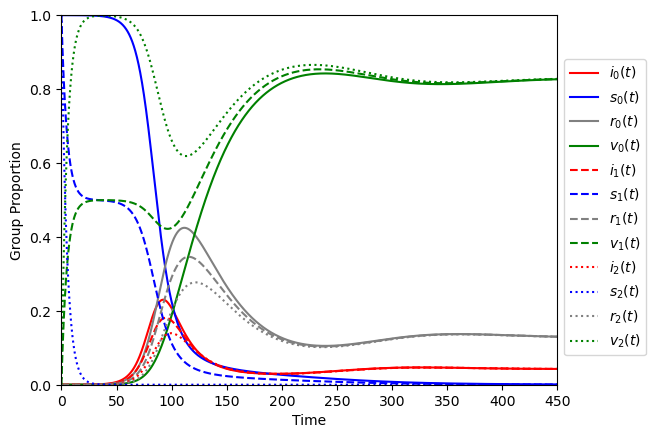

In [9]:
plot_results(all_su, all_sw, all_vn, all_v1, all_i, all_r, t, num_groups, savepath='../svir_mesa_lowhesitancy.png')

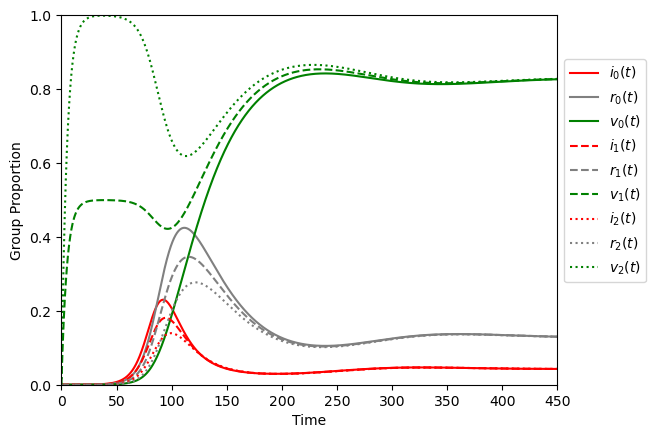

In [10]:
#ignore the susceptible category for clarity
ls = ['solid', 'dashed', 'dotted']

all_v = all_vn + all_v1

#plotting loop
for i in range(num_groups):
    plt.plot(t, all_i[i, :], color='red', linestyle=ls[i%len(ls)], label=rf'$i_{i}(t)$')
    plt.plot(t, all_r[i, :], color='gray', linestyle=ls[i%len(ls)], label=rf'$r_{i}(t)$')
    plt.plot(t, all_v[i, :], color='green', linestyle=ls[i%len(ls)], label=rf'$v_{i}(t)$')

plt.legend(bbox_to_anchor=(1, 0.9))

plt.xlim([t[0], t[-1]])
plt.ylim([0, 1])

plt.xlabel('Time')
plt.ylabel('Group Proportion')

plt.savefig('../vir_mesa_lowhesitancy.png', bbox_inches='tight', dpi=200)

plt.show()

### Second Simulation: High Hesitancy

This time, numbers are taken from the higher end of the estimate.

In [11]:
proportions = [0.27, 0.19, 0.54]
omegas = np.array(proportions)
C_row = [w / num_groups for w in omegas]
C = np.array([C_row for _ in range(num_groups)])

#solve
su, sw, vn, v1, i, r, t = solve(su_init, sw_init, vn_init, v1_init, i_init, r_init, p, 
                                C, omegas, delta_t, max_t, gamma, VEs, theta, alpha, psi)

#rework results so the final arrays have the two groups as the rows and their values over time as columns
all_su = concatenate(su)
all_sw = concatenate(sw)
all_vn = concatenate(vn)
all_v1 = concatenate(v1)
all_i = concatenate(i)
all_r = concatenate(r)

final_stats(all_su, all_sw, all_vn, all_v1, all_i, all_r, t, proportions, N, num_groups)

FINAL STATISTICS
--------------------------------------------------
GROUP 0:
--------------------------------------------------
Total Susceptible at EOS: 0.001
	 Unwilling susceptibles: 0.001
	 Willing susceptibles: 0.000
Total Immunized at EOS: 0.826
	 Highest protection: 0.158
	 Waned protection: 0.668
Total Infected at EOS: 0.043
Total Recovered at EOS: 0.130

Group Size: 27000 individuals (27.000% of the total pop.)
Cumulative Infections: 4992430.703
Infectious Peak Size: 6209.645 (22.999% of total group)
	Occured at time 92.25
--------------------------------------------------
GROUP 1:
--------------------------------------------------
Total Susceptible at EOS: 0.000
	 Unwilling susceptibles: 0.000
	 Willing susceptibles: 0.000
Total Immunized at EOS: 0.827
	 Highest protection: 0.158
	 Waned protection: 0.669
Total Infected at EOS: 0.043
Total Recovered at EOS: 0.130

Group Size: 19000 individuals (19.000% of the total pop.)
Cumulative Infections: 3234373.531
Infectious Peak Size

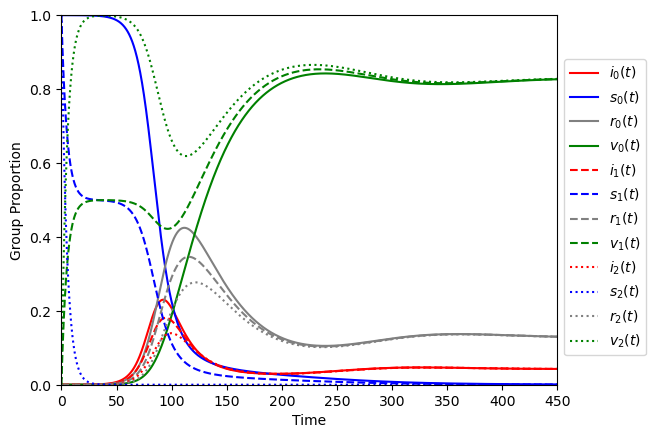

In [12]:
plot_results(all_su, all_sw, all_vn, all_v1, all_i, all_r, t, num_groups, savepath='../svir_mesa_highhesitancy.png')

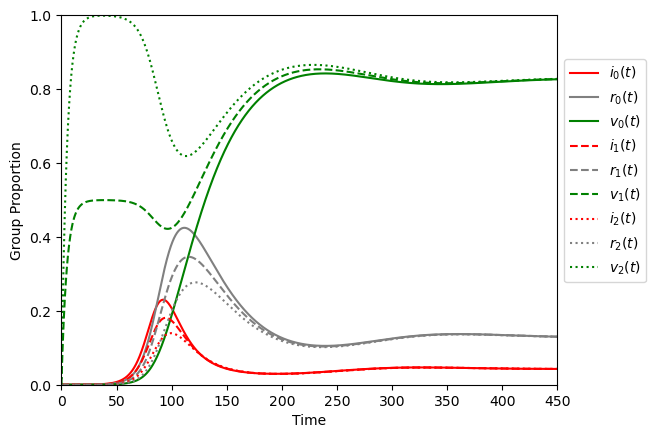

In [13]:
#ignore the susceptible category for clarity
ls = ['solid', 'dashed', 'dotted']

all_v = all_vn + all_v1

#plotting loop
for i in range(num_groups):
    plt.plot(t, all_i[i, :], color='red', linestyle=ls[i%len(ls)], label=rf'$i_{i}(t)$')
    plt.plot(t, all_r[i, :], color='gray', linestyle=ls[i%len(ls)], label=rf'$r_{i}(t)$')
    plt.plot(t, all_v[i, :], color='green', linestyle=ls[i%len(ls)], label=rf'$v_{i}(t)$')

plt.legend(bbox_to_anchor=(1, 0.9))

plt.xlim([t[0], t[-1]])
plt.ylim([0, 1])

plt.xlabel('Time')
plt.ylabel('Group Proportion')

plt.savefig('../vir_mesa_highhesitancy.png', bbox_inches='tight', dpi=200)

plt.show()

## Impact of Vaccine Distribution and Infectiousness

The next models look at the effects of vaccine distribution speed and infectiousness on an epidemic. What happens when vaccines can be distributed faster than the infection can spread? What happens when vaccine distribution is slower than the virus?

**Explanation of Initial Conditions:**
* $\omega_i$: The proportion of the population in group $i$. For this set of experiments, there will be two populations, each of which are equally sized.
* $\theta_i$: The rate of vaccine distribution to group $i$. In this model, $\theta_0 = 1/2$ and $\theta_1 = 1/8$.
* $\phi_i$: The proportion of group $i$ that is unwilling to be vaccinated. For this model, $\phi_i =  0.1$ for all $i$.
* $p$: The likelihood of infection given contact with a sick person. For this model p = 1/4, so that group 0 gets vaccinated at a rate that is faster than the likelihood of infection, and group 1 does not.

In [5]:
#set up shared initial conditions
N = 100000
num_groups = 2
VEs = [0.8, 0.6]
gamma = 1/10
phis = [1/10, 1/10]
alpha_const = 1/40
alpha  = make_vector(alpha_const, num_groups)
psi = 1/30

t_init = 0
delta_t = 0.125

i_0 = 1 / N
vn_0 = 0 #assume no one is vaccinated at beginning
v1_0 = 0
s0 = 1 - i_0
r_0 = 0

#create arrays and vectors
proportions = [0.5, 0.5]
omegas = np.array(proportions)

#implement contact
C_row = [w / num_groups for w in omegas]
C = np.array([C_row for _ in range(num_groups)])

#compute proportion of susceptible, infected, etc for each group
su_init = np.array([phi * s0 for phi in phis]).reshape((num_groups, 1))
sw_init = np.array([(1 - phi) * s0 for phi in phis]).reshape((num_groups, 1))
vn_init = make_vector(vn_0, num_groups)
v1_init = make_vector(v1_0, num_groups)
i_init = make_vector(i_0, num_groups)
r_init = make_vector(r_0, num_groups)

### First Experiment: Low Likelihood of Infection

This experiment assumes that the probability of infection is smaller than the rate of vaccine distribution for half the population.

In [6]:
#ICs
p = 1/4
theta = np.array([1/2, 1/10]).reshape((num_groups, 1))
max_t = 30

#solve
su, sw, vn, v1, i, r, t = solve(su_init, sw_init, vn_init, v1_init, i_init, r_init, p, 
                                C, omegas, delta_t, max_t, gamma, VEs, theta, alpha, psi)

#rework results so the final arrays have the two groups as the rows and their values over time as columns
all_su = concatenate(su)
all_sw = concatenate(sw)
all_vn = concatenate(vn)
all_v1 = concatenate(v1)
all_i = concatenate(i)
all_r = concatenate(r)

final_stats(all_su, all_sw, all_vn, all_v1, all_i, all_r, t, proportions, N, num_groups)

FINAL STATISTICS
--------------------------------------------------
GROUP 0:
--------------------------------------------------
Total Susceptible at EOS: 0.100
	 Unwilling susceptibles: 0.100
	 Willing susceptibles: 0.000
Total Immunized at EOS: 0.900
	 Highest protection: 0.447
	 Waned protection: 0.453
Total Infected at EOS: 0.000
Total Recovered at EOS: 0.000

Group Size: 50000 individuals (50.000% of the total pop.)
Cumulative Infections: 154.210
Infectious Peak Size: 0.687 (0.001% of total group)
	Occured at time 30.0
--------------------------------------------------
GROUP 1:
--------------------------------------------------
Total Susceptible at EOS: 0.144
	 Unwilling susceptibles: 0.100
	 Willing susceptibles: 0.044
Total Immunized at EOS: 0.856
	 Highest protection: 0.508
	 Waned protection: 0.348
Total Infected at EOS: 0.000
Total Recovered at EOS: 0.000

Group Size: 50000 individuals (50.000% of the total pop.)
Cumulative Infections: 215.369
Infectious Peak Size: 1.002 (0.00

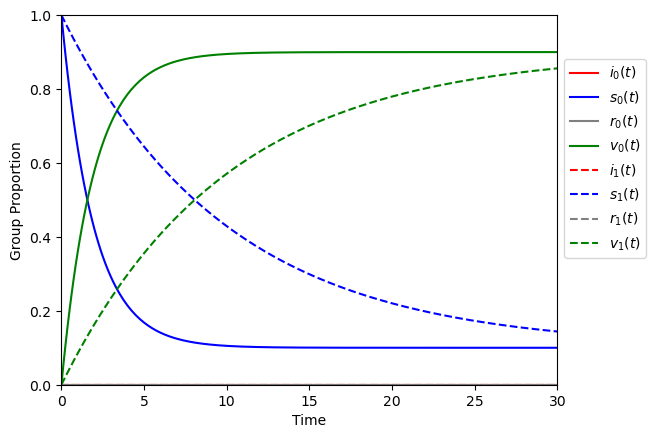

In [7]:
plot_results(all_su, all_sw, all_vn, all_v1, all_i, all_r, t, num_groups, savepath='../svir_vax_dist_vs_infectiousness.png')

### Second Experiment: Greater Likelihood of Infection.

This model assumes that the probability of infection given contact is much higher than the rate of vaccine distribution.

In [8]:
#ICs
p = 4/5
theta = np.array([1/2, 1/10]).reshape((num_groups, 1))
max_t = 250

#solve
su, sw, vn, v1, i, r, t = solve(su_init, sw_init, vn_init, v1_init, i_init, r_init, p, 
                                C, omegas, delta_t, max_t, gamma, VEs, theta, alpha, psi)

#rework results so the final arrays have the two groups as the rows and their values over time as columns
all_su = concatenate(su)
all_sw = concatenate(sw)
all_vn = concatenate(vn)
all_v1 = concatenate(v1)
all_i = concatenate(i)
all_r = concatenate(r)

final_stats(all_su, all_sw, all_vn, all_v1, all_i, all_r, t, proportions, N, num_groups)

FINAL STATISTICS
--------------------------------------------------
GROUP 0:
--------------------------------------------------
Total Susceptible at EOS: 0.000
	 Unwilling susceptibles: 0.000
	 Willing susceptibles: 0.000
Total Immunized at EOS: 0.458
	 Highest protection: 0.290
	 Waned protection: 0.168
Total Infected at EOS: 0.136
Total Recovered at EOS: 0.406

Group Size: 50000 individuals (50.000% of the total pop.)
Cumulative Infections: 12844906.361
Infectious Peak Size: 14679.360 (29.359% of total group)
	Occured at time 54.0
--------------------------------------------------
GROUP 1:
--------------------------------------------------
Total Susceptible at EOS: 0.000
	 Unwilling susceptibles: 0.000
	 Willing susceptibles: 0.000
Total Immunized at EOS: 0.458
	 Highest protection: 0.290
	 Waned protection: 0.168
Total Infected at EOS: 0.136
Total Recovered at EOS: 0.406

Group Size: 50000 individuals (50.000% of the total pop.)
Cumulative Infections: 12822045.574
Infectious Peak Si

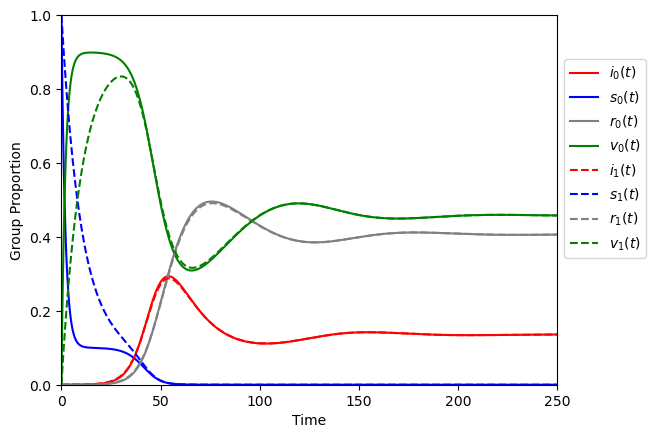

In [9]:
plot_results(all_su, all_sw, all_vn, all_v1, all_i, all_r, t, num_groups, savepath='../svir_vax_dist_vs_infectiousness_high_p.png')